<a href="https://colab.research.google.com/github/Akpuski/Kene-portfolio/blob/main/Netflix_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this project is to build a recommendation system to recommend movies to users based on the ratings given to different movies by the users.

In [ ]:
# Installing surprise library, only do it for first time
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811627 sha256=f9f62df0dbe7ce919f0701662703ee7610f19847e701d0f50cafc8e06708fc44
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

In [ ]:
# Import the dataset
rating = pd.read_csv('ratings.csv')

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
# Dropping the timestamp column
rating=rating.drop('timestamp', axis = 1)
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


Describe the distribution of ratings

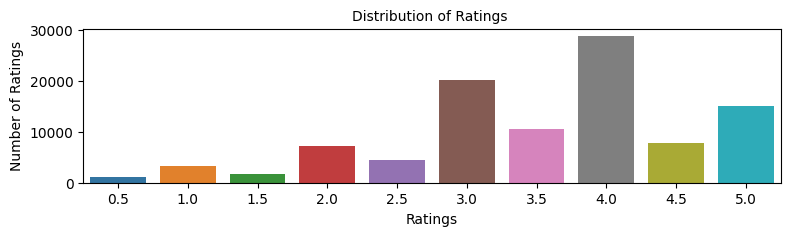

In [ ]:
plt.figure(figsize = (9, 2))

sns.countplot(x='rating', data = rating )

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

The total number of unique users and unique movies

In [ ]:
rating['userId'].nunique()

671

In [ ]:
rating.nunique()['movieId']

9066

is there a movie in which the same user interacted with it more than once.

In [ ]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [ ]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

From the results the user have interacted mostly once with the movieId.

The most interacted movie in the data set

In [ ]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

Movie with the highest interaction is 341.

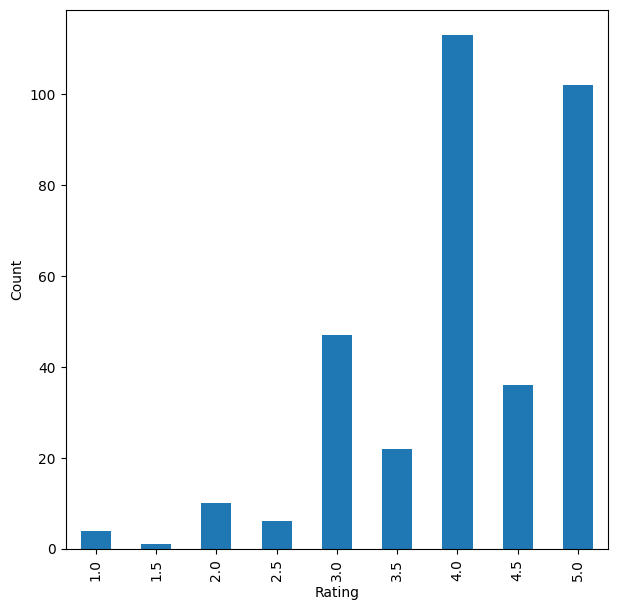

In [ ]:
# Plotting the distributions of ratings for 341 interactions with movieid 356
plt.figure(figsize= (7,7))
rating[rating['movieId']==356]['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel ("Rating")
plt.ylabel('Count')
plt.show()

The User that interacted the most with data set

In [ ]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

User 547 interacted the most with the item

The distribution of user, movie interaction on the data

In [ ]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

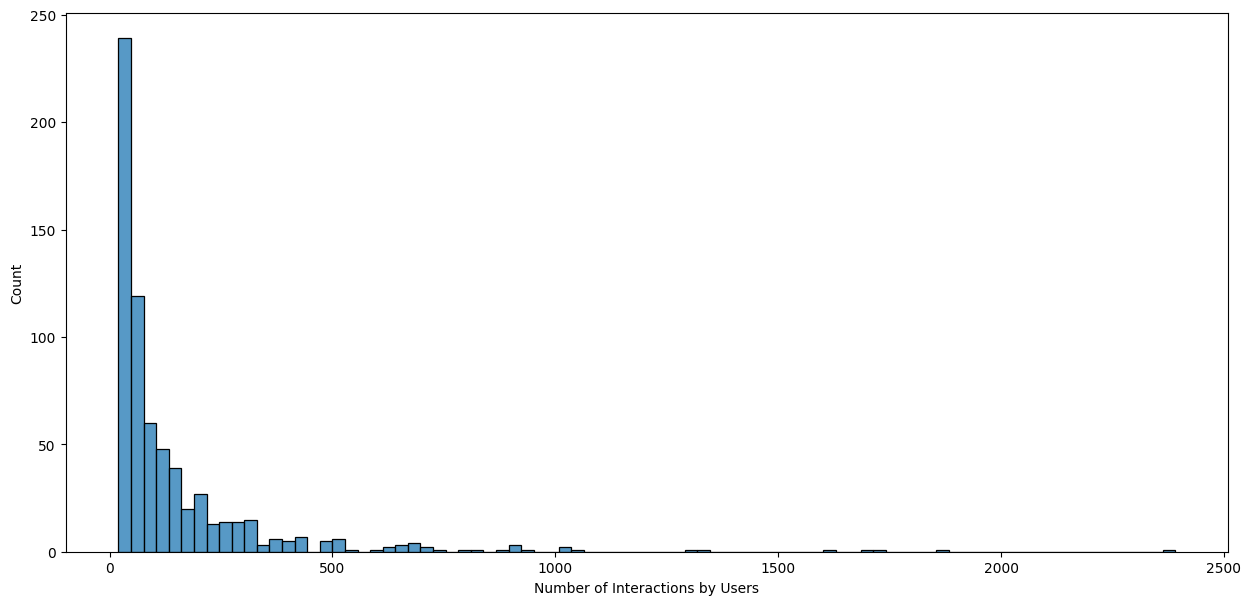

In [ ]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))


sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

The distribution of user is right skewed, only a few users interacted more than 500 items.

Model 1: Rank-Based Recommendation System

In [ ]:
# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [ ]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, i created a function to find the top n movies for a recommendation based on the average ratings of movies.

In [ ]:
def top_n_movies(data, n, min_interaction=100):
  #Finding movies with minimum number of interactions
  recommendation = data[data['rating_count']>=min_interaction]
  #Sorting values with respect to average rating
  recommendation = recommendation.sort_values('avg_rating', ascending=False)
  return recommendation.index[:n]


Recommending top 5 movies with 50 minimum interactions based on popularity

In [ ]:
list(top_n_movies(final_rating, 5,50))

[858, 318, 969, 913, 1221]

Model 2: User based Collaborative Filtering Recommendation System

Making the dataset into surprise dataset and splitting it into train and test set

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))
# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)
# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Build the first baseline similarity based recommendation system using cosine similarity and KNN

In [ ]:
# Defining Nearest neighbour algorithm
algo_knn = {'name': 'cosine', 'user_based': True}

algo_knn_user = KNNBasic(algo_knn = algo_knn,verbose=False, random_state=1)

# Train the algorithm on the trainset or fitting the model on train dataset
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9672


0.9671524784958385

The Predicted rating for a user with userId=4 and for movieId=10 and movieId=3

In [ ]:
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.68   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.680292946370331, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
algo_knn_user.predict(4,3, r_ui=4, verbose=True)

user: 4          item: 3          r_ui = 4.00   est = 3.31   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=4, est=3.3125531823311247, details={'actual_k': 40, 'was_impossible': False})

Improving user-user similarity based recommendation system by tuning its hyper-parameters.

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])


0.9661640266894338
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


In [ ]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.967983,0.965353,0.965156,0.966164,0.001289,1,0.742990,0.743892,0.742023,0.742968,0.000763,1,0.133744,0.086611,2.347766,0.221836,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.997296,0.994153,0.993880,0.995110,0.001550,14,0.769612,0.770253,0.768066,0.769311,0.000918,14,0.230508,0.033367,1.858881,0.037371,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.972177,0.968951,0.967543,0.969557,0.001940,3,0.746472,0.746086,0.744078,0.745546,0.001049,3,0.067054,0.008892,1.902669,0.045095,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.999812,0.996404,0.994709,0.996975,0.002122,15,0.771937,0.771289,0.768926,0.770717,0.001294,15,0.124865,0.020002,2.031641,0.128776,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.977531,0.975844,0.972763,0.975379,0.001974,7,0.751508,0.751274,0.748526,0.750436,0.001354,7,0.169658,0.100807,2.189069,0.225541,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the final model by using tuned values of the hyperparameters, which we received by using grid search cross-validation.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_options = {'name': 'msd',
               'user_based': True}
similarity_algo_optimized_user = KNNBasic(sim_options = sim_options,k= 20, min_k = 3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)


RMSE: 0.9571


0.9571445417153293

The Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering

In [ ]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

In [ ]:
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

Identifying similar users to a given user (nearest neighbors)

Below we are finding 5 most similar user to the userId=4 based on the msd distance metric

In [ ]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[665, 417, 647, 654, 260]

Implementing the recommendation algorithm based on optimized KNNBasic model

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended movie ids
    recommendations = []

    # Creating a user item interactions matrix
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')

    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:

        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

Predicted top 5 movies for userId=4 with similarity based recommendation system

In [ ]:
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

In [ ]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

Model 3: Item based Collaborative Filtering Recommendation System

In [ ]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3

In [ ]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
algo_knn_item.predict(4,3, r_ui=4, verbose=True)

user: 4          item: 3          r_ui = 4.00   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=4, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9395550141541621
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


In [ ]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.949895,0.955129,0.945965,0.950329,0.003754,8,0.733931,0.737580,0.729559,0.733690,0.003279,8,3.631815,0.643753,7.977896,0.046811,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.011748,1.017204,1.011787,1.013580,0.002563,17,0.789808,0.793634,0.788213,0.790552,0.002275,16,4.076905,0.448628,7.806052,0.082225,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.949721,0.954820,0.945769,0.950104,0.003705,7,0.734079,0.737568,0.729385,0.733677,0.003353,7,2.619274,0.193148,7.694779,0.314233,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.011706,1.017090,1.011503,1.013433,0.002587,16,0.789990,0.793719,0.787982,0.790563,0.002377,17,4.174217,0.915423,7.862190,0.769850,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.950396,0.955213,0.946573,0.950728,0.003535,9,0.734545,0.737952,0.730068,0.734188,0.003228,9,2.896212,0.318300,7.188950,0.013917,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the final model by using tuned values of the hyperparameters which we received by using grid search cross-validation

In [ ]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=40, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9430


0.9430205750839428

The Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering?

In [ ]:
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
similarity_algo_optimized_item.predict(4,3, r_ui=4, verbose=True)

user: 4          item: 3          r_ui = 4.00   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=4, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

Identifying similar items to a given item (nearest neighbors)

We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the movieId=3 based on the msd distance metric

In [ ]:
similarity_algo_optimized_item.get_neighbors(3, k=5)

[31, 37, 42, 48, 73]

Predicted top 5 movies for userId=4 with similarity based recommendation system



In [ ]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

In [ ]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3515, 5), (4521, 5)]

Model 4: Based Collaborative Filtering - Matrix Factorization using SVD

Build a baseline matrix factorization recommendation system

In [ ]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9048


0.9047880133167958

Let's us now predict rating for an user with userId=4 and for movieId=10

In [ ]:
algo_svd.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.16   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.1568713751941955, details={'was_impossible': False})

Let's predict the rating for the same userId=4 but for a movie which this user has not interacted before i.e. movieId=3:

In [ ]:
algo_svd.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.50   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.4995589934485096, details={'was_impossible': False})

Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8951397313825642
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()


,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.946309,0.943976,0.938495,0.942927,0.003275,25,0.738723,0.739349,0.735133,0.737735,0.001857,25,0.437327,0.025938,0.299294,0.011702,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.950378,0.948206,0.943491,0.947358,0.002875,26,0.743621,0.744148,0.740887,0.742885,0.001429,26,0.495919,0.035261,0.436875,0.089980,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.955574,0.953692,0.948692,0.952652,0.002904,27,0.749237,0.750016,0.746666,0.748639,0.001432,27,0.742469,0.076180,0.611245,0.027800,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.909532,0.908420,0.902416,0.906789,0.003125,10,0.702149,0.704557,0.699422,0.702043,0.002098,9,0.781769,0.161163,0.832658,0.270237,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.916781,0.915618,0.909832,0.914077,0.003039,15,0.709935,0.712224,0.707311,0.709823,0.002007,15,1.184920,0.405347,0.593221,0.110054,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


In [ ]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)


# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8951


0.8951220012037271

Let's us now predict rating for an user with userId=4 and for movieId=10 with the optimized model

In [ ]:
svd_algo_optimized.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9874397717023995, details={'was_impossible': False})

Let's predict the rating for the same userId=4 but for a movie which this user has not interacted before i.e. movieId=3:

In [ ]:
svd_algo_optimized.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.65   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6485474796681023, details={'was_impossible': False})

Predict the top 5 movies for userId=4 with SVD based recommendation system

In [ ]:
get_recommendations(rating, 4,5, svd_algo_optimized)

[(1192, 4.994317958480161),
 (116, 4.974792317473404),
 (926, 4.945766224974404),
 (1948, 4.942505976872586),
 (3310, 4.927460486590003)]

Predicting ratings for already interacted movies

Below we are comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [ ]:
def predict_already_interacted_ratings(data, user_id, algo):

    # Creating an empty list to store the recommended movie ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')

    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()

    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:

        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]

        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by similarity based recommendation system against actual ratings for userId=7

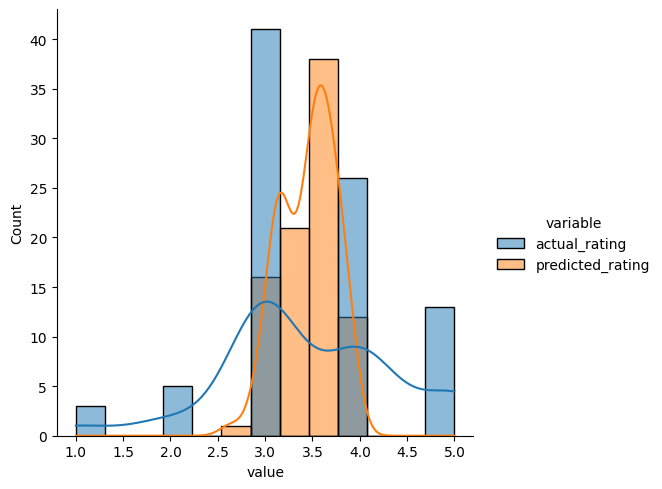

In [ ]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

Below we are comparing the predicted ratings by matrix factorization based recommendation system against actual ratings for userId=7

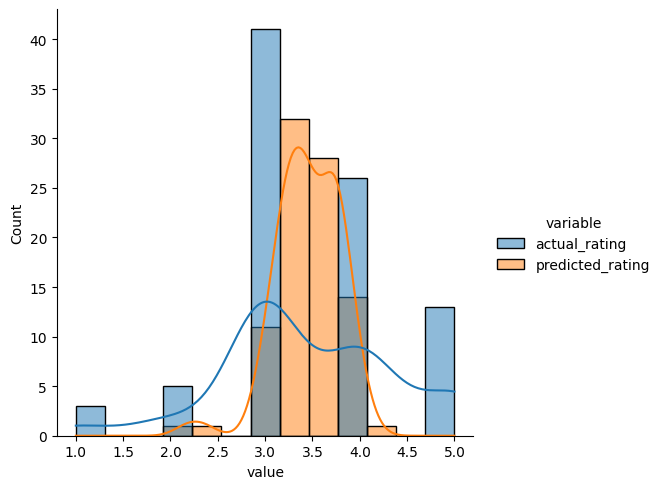

In [ ]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

 Compute the precision and recall, for each of the 6 models, at k = 5 and 10

In [ ]:

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Remove _______ and complete the code
# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]
for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.773
-----> Recall:  0.413
> k=5, model=KNNBasic
-----> Precision:  0.772
-----> Recall:  0.419
> k=5, model=KNNBasic
-----> Precision:  0.609
-----> Recall:  0.326
> k=5, model=KNNBasic
-----> Precision:  0.677
-----> Recall:  0.354
> k=5, model=SVD
-----> Precision:  0.755
-----> Recall:  0.386
> k=5, model=SVD
-----> Precision:  0.752
-----> Recall:  0.387
> k=10, model=KNNBasic
-----> Precision:  0.754
-----> Recall:  0.554
> k=10, model=KNNBasic
-----> Precision:  0.751
-----> Recall:  0.559
> k=10, model=KNNBasic
-----> Precision:  0.601
-----> Recall:  0.478
> k=10, model=KNNBasic
-----> Precision:  0.663
-----> Recall:  0.505
> k=10, model=SVD
-----> Precision:  0.73
-----> Recall:  0.517
> k=10, model=SVD
-----> Precision:  0.729
-----> Recall:  0.524
